# บทที่ 3a - การประเมินผลโมเดล Machine Learning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ai-builders/curriculum/blob/main/notebooks/03a_metrics_and_baselines.ipynb)

ในบทเรียนนี้ เราจะเรียนรู้วิธีการประเมินผลโมเดล Machine Learning เพื่อให้ได้โมเดลที่มีประสิทธิภาพสูงและใช้ได้จริง เราจะเริ่มทำความรู้จักจาก metric (ตัวชี้วัด) สำหรับการใช้งานทั่วไป ได้แก่ classification (การจำแนกชนิด), regression (การทำนายจำนวนจริง), ranking (การจัดลำดับ) พร้อมคำแนะนำในการเปรียบเทียบ metric เหล่านี้กับ baseline ที่แสดงให้เห็นถึงประสิทธิภาพของโมเดลเราอย่างยุติธรรม นอกจากนี้งานเฉพาะด้านเช่น image (object detection, semantic segmentation, image generation) และ texts (named entity recognition, translation, summarization, automatic speech recognition) จะมี metric สำหรับวัดผลเฉพาะสำหรับแต่ละงานที่จะสามารถเรียนรู้กันต่อได้ในบทเรียนที่ 4-6

In [6]:
# !pip install -q plotnine

In [11]:
from plotnine import *
theme_set(theme_minimal(11))
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Classification

Classification คือการทำนาย label (ชนิด) ของแต่ละตัวอย่างจาก feature ที่ให้มา แบ่งเป็น 2 ประเภทคือ

1. **Multi-class classification**; หนึ่งตัวอย่างมีได้เพียง 1 label ที่ถูกต้อง เช่น ทำนายว่ารูปภาพสุนัขนี้เป็นพันธุ์อะไร, ทำนายว่าลูกค้าคนนี้จะชอบโปรโมชั่นนี้หรือไม่, ประโยคนี้ให้ความรู้สึกเป็นบวก-ลบ-เฉยๆ เป็นต้น


2. **Multi-label classification**; หนึ่งตัวอย่างมีได้มากกว่า 1 label ที่ถูกต้อง เช่น ทำนายว่าบทความนี้มี tag อะไรบ้าง (การเมือง, เศรษฐกิจ, สังคม หรือปนๆกัน), ทำนายว่าสินค้าชนิดนี้เหมาะกับลูกค้ากลุ่มใดบ้าง (อาจจะเหมาะทั้งกับเด็กและผู้ใหญ่, เฉพาะเด็ก หรือเฉพาะผู้ใหญ่), ทำนายว่าคำในประโยคเป็นนามเฉพาะอะไร (อาจจะเป็นได้ทั้งสถาบันและสถานที่ เช่น โรงเรียนสวนกุหลาบ)

ในบทเรียนนี้เราจะเรียนรู้เกี่ยวกับ metric พื้นฐาน ได้แก่ accuracy, precision, recall, F1 และการดู confusion matrix ที่แสดงตัวเลขที่ไว้ใช้คำนวณค่าเหล่านี้

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools
def plot_confusion_matrix(cm, classes, 
                          percentify_numbers = True,
                          title='Confusion matrix', 
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    
    if percentify_numbers:
        cm = (100 * cm / cm.sum()).round().astype(int)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

ตัวอย่างการวัดผล classification เมื่อเรามีจำนวนตัวอย่างในแต่ละ label เท่าๆกัน สมมุติว่าเรามี test set สำหรับโมเดลทำนายพันธุ์สุนัข 5 พันธุ์ มี label ที่แท้จริงใน `actual` และคำทำนายของโมเดลตัวอย่างใน `pred`

In [49]:
#ตัวอย่าง multi-class classification
dog_breeds = ['Labrador Retriever', 
              'German Shepherd', 
              'Golden Retriever', 
              'Bulldog', 
              'Poodle']
np.random.seed(125)
num_samples = 300
actuals = np.random.choice(dog_breeds, size=num_samples)
randoms = np.random.choice(dog_breeds, size=num_samples)


prediction_logic = {
    'Labrador Retriever': ['Labrador Retriever', 'Golden Retriever', 'Poodle'],
    'German Shepherd': ['German Shepherd', 'Labrador Retriever', 'Golden Retriever'],
    'Golden Retriever': ['Golden Retriever', 'Labrador Retriever', 'Poodle'],
    'Bulldog': ['Bulldog', 'Golden Retriever'],
    'Poodle': ['Poodle', 'Labrador Retriever', 'Golden Retriever']
}
predictions = []
for actual in actuals:
    possible_predictions = prediction_logic[actual]
    pred = np.random.choice(possible_predictions)
    predictions.append(pred)

# Create the dataframe
df = pd.DataFrame({'actual': actuals, 'pred': predictions, 'pred_random': randoms})
df

,actual,pred,pred_random
0,Golden Retriever,Poodle,German Shepherd
1,Bulldog,Golden Retriever,Poodle
2,Poodle,Labrador Retriever,Poodle
3,Bulldog,Bulldog,Golden Retriever
4,Bulldog,Bulldog,German Shepherd
...,...,...,...
295,Labrador Retriever,Labrador Retriever,Bulldog
296,Bulldog,Golden Retriever,Bulldog
297,Bulldog,Bulldog,Golden Retriever
298,Golden Retriever,Labrador Retriever,Golden Retriever


Metric สำหรับวัดผลโมเดล classification แทบทุกอันมีพื้นฐานมาจากตาราง confusion matrix แถวของ confusion matrix คือ label ที่เป็นจริง (ground truth, true label) และคอลัมน์คือ label ที่แต่ละโมเดลทำนาย (prediction) เพราะฉะนั้นโมเดลที่สมบูรณ์แบบจะทำนายให้ตัวอย่างทั้งหมดอยู่บนเส้นแทยงมุม

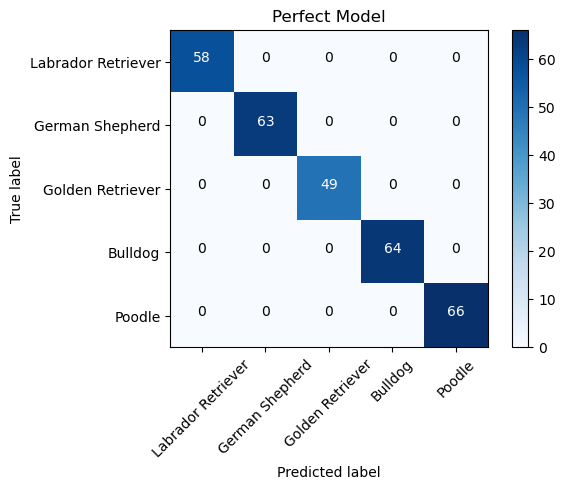

In [57]:
#confusion matrix ของโมเดลที่สมบูรณ์แบบ
cm = confusion_matrix(y_true=df.actual, y_pred=df.actual)
plot_confusion_matrix(cm, 
                      classes=dog_breeds,
                      percentify_numbers = False,
                      title="Perfect Model")

ลองเปรียบเทียบกับโมเดลตัวอย่างของเรา (`pred`) จะเห็นได้ว่าโมเดลของเราทำได้ถูกต้องทั้งหมดเมื่อทายว่า `Labrador Retriever` และ `German Shepherd` แต่ผิดพลาดสำหรับพันธุ์ที่เหลือ เช่น ทายว่า `Golden Retriever` ทั้งที่เป็น `Poodle` 27 ตัว, ทายว่าเป็น `Bulldog` ทั้งที่เป็น `Golden Retriever` 17 ตัว เป็นต้น

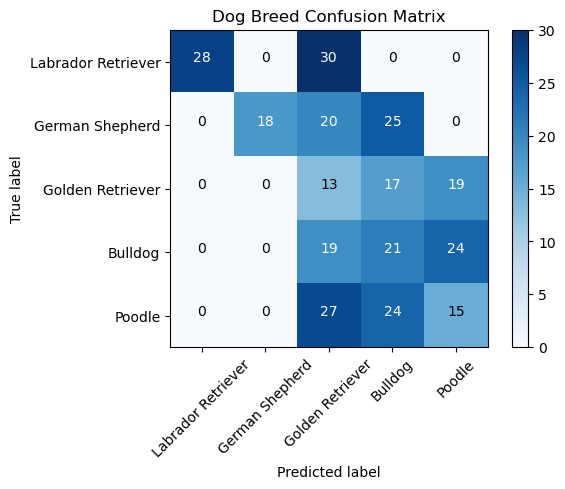

In [58]:
#confusion matrix ของโมเดลตัวอย่าง
cm = confusion_matrix(y_true=df.actual, y_pred=df.pred)
plot_confusion_matrix(cm, 
                      classes=dog_breeds,
                      percentify_numbers = False,
                      title="Dog Breed Confusion Matrix")

เรารู้ว่าโมเดลเราทำได้แย่กว่าโมเดลสมบูรณ์แบบ (ในโลกแห่งความเป็นจริงแทบไม่มีโมเดลที่ทำได้สมบูรณ์แบบ จริงๆแล้วถ้าคุณทำโมเดลออกมาแล้วสมบูรณ์แบบ คุณน่าจะต้องสงสัยว่าคุณทำอะไรผิด) แต่เราจะรู้ได้ยังไงว่าโมเดลของเราดีแค่ไหน? นี่คือเหตุผลว่าทำไมเราถึงต้องมี baseline เพื่อเปรียบเทียบ

Baseline ง่ายๆสำหรับการทำ classification มีได้เช่น

1. **ดิ่งช้อยส์**; เลือกทำนายชนิดที่มีจำนวนมากที่สุดใน test set ในกรณีของเราคือ `Poodle`
2. **ทายมั่ว**; ทำนายมั่วๆไปเลยจากชนิดที่มีอยู่ (`pred_random`)
3. **เทียบกับมนุษย์**; baseline ที่น่าจะยากที่สุดสำหรับ ML model คือการเทียบว่ามันทำได้ดีแค่ไหนถ้าเทียบกับมนุษย์ เราอาจจะต้องไปเก็บข้อมูลแบบสอบถามให้มากพอที่จะน่าเชื่อถือ

In [50]:
df.actual.value_counts()

Poodle                66
Labrador Retriever    64
German Shepherd       63
Bulldog               58
Golden Retriever      49
Name: actual, dtype: int64

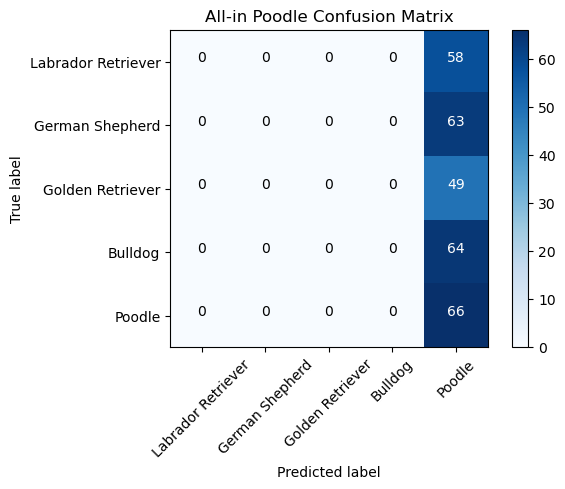

In [62]:
#confusion metric ของการดิ่ง Poodle
df['pred_majority'] = df.actual.value_counts().index[0]
cm = confusion_matrix(y_true=df.actual, y_pred=df.pred_majority)
plot_confusion_matrix(cm, 
                      classes=dog_breeds,
                      percentify_numbers = False,
                      title="All-in Poodle Confusion Matrix")

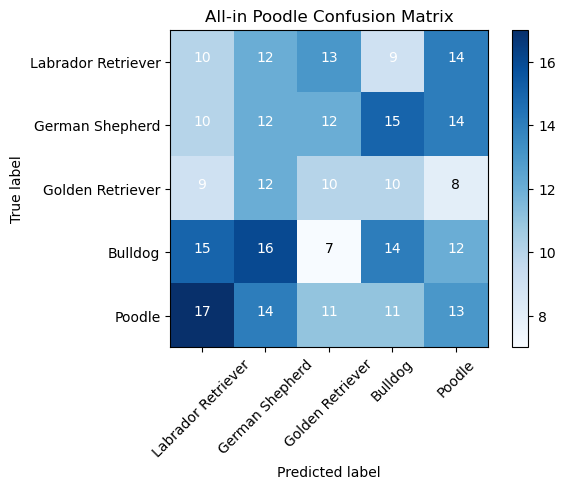

In [63]:
#confusion metric ของการทายมั่ว
cm = confusion_matrix(y_true=df.actual, y_pred=df.pred_random)
plot_confusion_matrix(cm, 
                      classes=dog_breeds,
                      percentify_numbers = False,
                      title="All-in Poodle Confusion Matrix")

หากดูด้วยตาเราอาจจะพอคาดการณ์ได้ว่าโมเดลตัวอย่างนั้นทำได้ดีกว่าการดิ่ง Poodle และทายมั่ว แต่เราไม่สามารถดูด้วยตาแบบนี้ได้ในทุกกรณี โดยเฉพาะกรณีที่มีโมเดลที่มีประสิทธิภาพใกล้เคียงกัน เราจึงต้องคำนวณ metric 1 ตัวเลขต่อ 1 โมเดลจากข้อมูล confusion matrix ข้างต้น 

Metric พื้นฐานเหล่านั้นได้แก่

1. Accuracy; ทำนายถูกหรือผิดกี่ตัวอย่างจากทั้งหมด; ผลรวมของจำนวนตัวอย่างใน`เส้นทแยงมุม`ของ confusion matrix หารด้วยจำนวน`ตัวอย่างทั้งหมด`


2. Precision; จากตัวอย่างที่โมเดลทำนายเป็น label นั้นๆ มีถูกกี่อัน; จำนวนตัวอย่างที่ทายถูกใน`คอลั่มนั้นๆ`หารด้วยผลรวมของจำนวนตัวอย่างทั้งหมดใน`คอลั่ม`


3. Recall; จากตัวอย่างที่เป็น label นั้นๆจริง โมเดลทำนายถูกกี่อัน; จำนวนตัวอย่างที่ทายถูกใน`แถวนั้นๆ`หารด้วยผลรวมของจำนวนตัวอย่างทั้งหมดใน`แถว`

4. F1; ค่า harmonic mean ของ precision และ recall

การเลือกใช้ precision และ recall นั้น เราต้องทำความเข้าใจ false positive (ทำนายว่าเป็น label นั้น แต่จริงๆไม่ใช่) และ false negative (ทำนายว่าไม่ได้เป็น label นั้นแต่จริงๆเป็น) 

เราสนใจ precision มากเป็นพิเศษเมื่อราคาของ false positive นั้นสูง เช่น ทำนายหุ้นที่ซื้อแล้วจะขึ้น หากเราทำนายตัวที่จะซื้อผิด (false positive) เราเสียเงินทันที ในทางกลับกัน ต่อให้เราไม่ซื้อหุ้นที่จริงๆแล้วจะขึ้น (false negative) เราก็แค่เสียโอกาส

เราสนใจ recall มากเป็นพิเศษเมื่อราคาของ false negative นั้นสูง เช่น การตรวจมะเร็ง หากเราทำนายว่าคนที่เป็นมะเร็งจริงๆไม่เป็น (false negative) อาจจะก่อให้เกิดความล่าช้าในการรักษาส่งผลต่อสุขภาพทันที ในทางกลับกันถ้าเราทำนายว่าเขาเป็นทั้งๆที่ไม่ได้เป็น (false positive) เขาอาจจะต้องเสียเวลาตรวจละเอียดมากขึ้น แต่ไม่ได้มีผลต่อสุขภาพ

In [68]:
#classification metric สำหรับโมเดลตัวอย่าง
cr = classification_report(y_true=df.actual,
                          y_pred=df.pred,
                          labels=dog_breeds)
print(cr)

                    precision    recall  f1-score   support

Labrador Retriever       0.24      0.33      0.28        64
   German Shepherd       1.00      0.29      0.44        63
  Golden Retriever       0.12      0.27      0.16        49
           Bulldog       1.00      0.48      0.65        58
            Poodle       0.26      0.23      0.24        66

          accuracy                           0.32       300
         macro avg       0.52      0.32      0.36       300
      weighted avg       0.53      0.32      0.36       300



In [75]:
macro_precision = (0.24+1.0+0.12+1.0+0.26)/5
macro_precision

0.524

In [76]:
micro_precision = (0.24*64+1.0*63+0.12*49+1.0*58+0.26*66)/300
micro_precision

0.5313333333333333

In [77]:
#classification metric สำหรับการดิ่ง Poodle
cr = classification_report(y_true=df.actual,
                          y_pred=df.pred_majority,
                          labels=dog_breeds)
print(cr)

                    precision    recall  f1-score   support

Labrador Retriever       0.00      0.00      0.00        64
   German Shepherd       0.00      0.00      0.00        63
  Golden Retriever       0.00      0.00      0.00        49
           Bulldog       0.00      0.00      0.00        58
            Poodle       0.22      1.00      0.36        66

          accuracy                           0.22       300
         macro avg       0.04      0.20      0.07       300
      weighted avg       0.05      0.22      0.08       300



/home/charipol/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/home/charipol/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/home/charipol/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [78]:
#classification metric สำหรับการทายมั่ว
cr = classification_report(y_true=df.actual,
                          y_pred=df.pred_random,
                          labels=dog_breeds)
print(cr)

                    precision    recall  f1-score   support

Labrador Retriever       0.24      0.22      0.23        64
   German Shepherd       0.18      0.19      0.19        63
  Golden Retriever       0.19      0.20      0.20        49
           Bulldog       0.16      0.17      0.17        58
            Poodle       0.21      0.20      0.20        66

          accuracy                           0.20       300
         macro avg       0.20      0.20      0.20       300
      weighted avg       0.20      0.20      0.20       300



เนื่องจากเราคำนวณ metric สำหรับแต่ละ label แยกกัน เราจึงต้องมีวิธีการหาค่าเฉลี่ยระหว่าง label ด้วย

1. Macro-average; นำค่า precision, recall, F1 จากแต่ละ label มาหาค่าเฉลี่ยกัน
2. Micro-average/Weighted average; หาค่าเฉลี่ยที่ถ่วงน้ำหนักด้วยจำนวนตัวอย่างในแต่ละ label (`support`)

หากจำนวนตัวอย่างในแต่ละ label มีเท่าๆกัน macro-average และ micro-average จะออกมาใกล้เคียงกัน แต่ในกรณีที่มีบาง label มีจำนวนตัวอย่างมากหรือน้อยเป็นพิเศษ การใช้ micro-average จะทำให้ metric เฉลี่ยดูดีหาก metric ของ label ที่มีจำนวนตัวอย่างมากเป็นพิเศษออกมาดี

ในกรณีที่จำนวนตัวอย่างใน label ต่างกันมาก ยกตัวอย่างกรณีโมเดลตรวจโรค แน่นอนว่าคนส่วนใหญ่ที่มาตรวจสุขภาพนั้นไม่ได้เป็นโรค ในกรณีนี้หากเราใช้ accuracy หรือ micro-average ในการคำนวณ metric อาจจะได้ผลสรุปที่ไม่ตรงความจริง

In [81]:
#ตัวอย่าง multi-class classification
labels = ['Healthy','Diseased']
np.random.seed(125)
num_samples = 300
actuals = np.random.choice(labels, size=num_samples, p=[0.99,0.01])

# Create the dataframe
df = pd.DataFrame({'actual': actuals, 'pred': 'Healthy'})
df

,actual,pred
0,Healthy,Healthy
1,Healthy,Healthy
2,Healthy,Healthy
3,Healthy,Healthy
4,Healthy,Healthy
...,...,...
295,Healthy,Healthy
296,Healthy,Healthy
297,Healthy,Healthy
298,Healthy,Healthy


จากตัวอย่าง ถ้า 99% ของคนไข้สุขภาพดี เพียงแค่เราทำนายว่าทุกคนจะสุขภาพดี เราก็จะได้ accuracy และ micro-average ที่สูงมาก แต่หากดู confusion matrix เราก็จะรู้ว่าโมเดลไม่ได้ทำได้ดีเลย กรณีแบบนี้เราจึงควรใส่ใจ macro-average มากกว่า

In [84]:
cr = classification_report(y_true=df.actual,
                          y_pred=df.pred,
                          labels=labels)
print(cr)

              precision    recall  f1-score   support

     Healthy       0.99      1.00      0.99       297
    Diseased       0.00      0.00      0.00         3

    accuracy                           0.99       300
   macro avg       0.49      0.50      0.50       300
weighted avg       0.98      0.99      0.99       300



/home/charipol/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/home/charipol/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/home/charipol/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


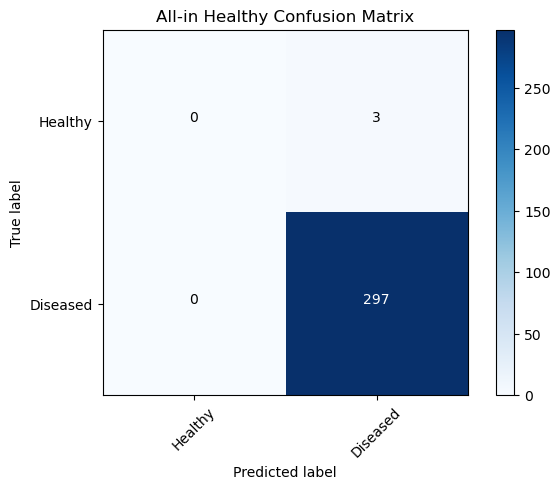

In [83]:
#confusion metric ของการดิ่ง Healthy
cm = confusion_matrix(y_true=df.actual, y_pred=df.pred)
plot_confusion_matrix(cm, 
                      classes=labels,
                      percentify_numbers = False,
                      title="All-in Healthy Confusion Matrix")

## Regression

Regression เป็นงานทำนาย outcome ที่เป็นจำนวนจริงของแต่ละตัวอย่างจาก feature ที่ให้มา โดยทั่วไปแล้วเราควรจะรู้ว่า outcome ที่เป็นจำนวนจริงของเรานั้นมีการกระจายอย่างไร เช่น 

1. Normal distribution กระจายตัวเป็นรูประฆังคว่ำรอบค่าเฉลี่ย มักพบในข้อมูลที่เก็บจากธรรมชาติ เช่น น้ำหนัก ส่วนสูงฯลฯ หรือ 

2. Power-law distribution ที่ตัวอย่างส่วนใหญ่กระจุกอยู่ระหว่างช่วงจำนวนใดจำนวนหนึ่ง มันพบในข้อมูลที่เกิดจากพฤติกรรมมนุษย์ เช่น ยอดขายของลูกค้าที่มักจะมีลูกค้าชั้นดีส่วนน้อยที่ใช้จ่ายเยอะและที่เหลือส่วนใหญ่เป็นลูกค้าที่ใช้จ่ายน้อย เป็นต้น

เพื่อให้เลือกใช้ metric ในการวัดผลได้อย่างเหมาะสม 

In [150]:
np.random.seed(125)
num_samples = 300

# Power-law distribution parameters
alpha = 20.0  # Shape parameter
xmin = 1.0  # Minimum value

# Generate 'actual' values from a power-law distribution
actual_values = (np.random.pareto(alpha, num_samples) + 1) * xmin

# Generate 'pred' values with some noise
pred_values = actual_values + np.random.normal(0, 0.05, num_samples)  # Adding noise

# Create a DataFrame
df = pd.DataFrame({'actual': actual_values, 'pred': pred_values})
df

,actual,pred
0,1.035966,1.080678
1,1.002967,1.029749
2,1.050626,1.073544
3,1.007135,1.113163
4,1.007050,1.010675
...,...,...
295,1.112177,1.116984
296,1.033367,1.061958
297,1.045013,0.935497
298,1.058594,1.058634


เช่นเดียวกับการวัดผล classification สิ่งที่สำคัญที่สุดคือการพลอตข้อมูล `actual` และ `pred` ออกมาดูเพื่อให้เห็นการกระจายตัวจริงๆว่าใกล้เคียงกันแค่ไหน

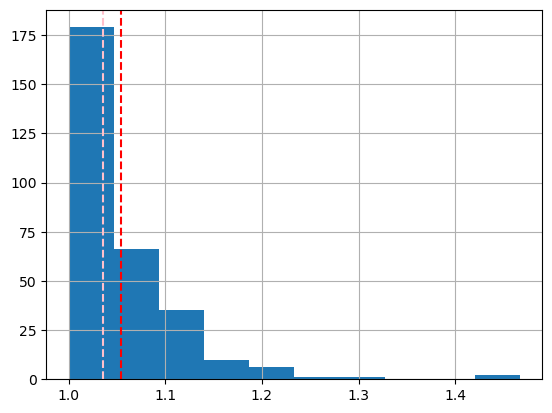

In [151]:
#ดูว่าค่าจริงกระจายตัวอย่างไร
#สีแดง mean; สีชมพู median
df.actual.hist()
plt.axvline(x=df.actual.mean(), color='red', linestyle='--', label='Mean') 
plt.axvline(x=df.actual.median(), color='pink', linestyle='--', label='Median') 

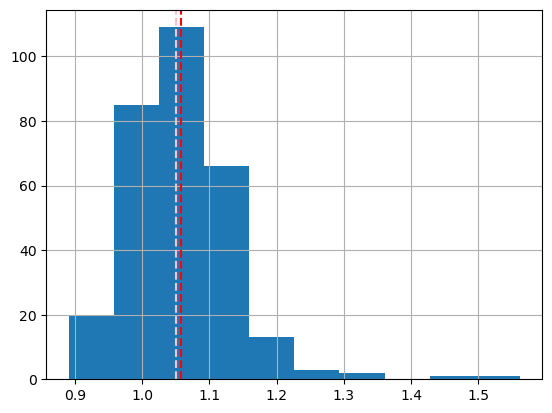

In [152]:
#ดูว่าค่าทำนายกระจายตัวอย่างไร
#สีแดง mean; สีชมพู median
df.pred.hist()
plt.axvline(x=df.pred.mean(), color='red', linestyle='--', label='Mean') 
plt.axvline(x=df.pred.median(), color='pink', linestyle='--', label='Median') 

<AxesSubplot:>

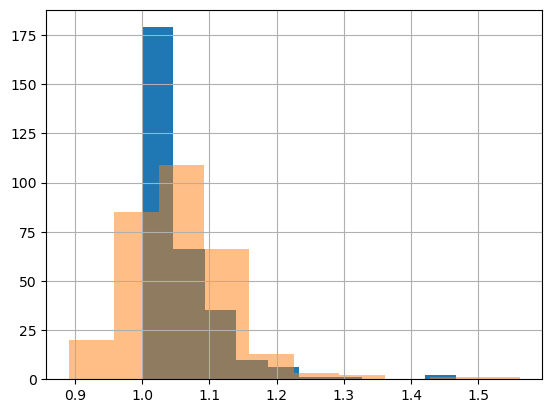

In [153]:
#เทียบการกระจายตัวของค่าจริงและค่าทำนาย
df.actual.hist()
df.pred.hist(alpha=0.5)

<AxesSubplot:xlabel='pred', ylabel='actual'>

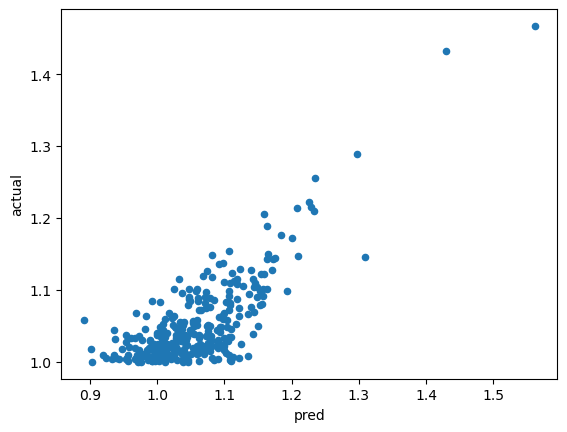

In [154]:
#scatter plot ค่าจริงและค่าทำนาย
df.plot.scatter(x='pred',y='actual')

เช่นเดียวกับ classification การที่เราจะบอกว่าโมเดลของเราทำได้ดีหรือไม่นั้นเราจำเป็นต้องมี baseline และ metric ที่ใช้เปรียบเทียบนอกจากการพลอตข้อมูลออกมาดู baseline ที่นิยมใช้ได้แก่

1. ค่า mean, median หรือ mode; ด้วยแนวคิดเดียวกับการดิ่งช้อยส์ของ classification เราอาจจะทำนายว่าทุกตัวอย่างมีค่าเท่ากับค่ากลางอันใดอันหนึ่ง

2. **เทียบกับมนุษย์**; baseline ที่น่าจะยากที่สุดสำหรับ ML model คือการเทียบว่ามันทำได้ดีแค่ไหนถ้าเทียบกับมนุษย์ เราอาจจะต้องไปเก็บข้อมูลแบบสอบถามให้มากพอที่จะน่าเชื่อถือ

ในบทเรียนนี้เราจะกล่าวถึง regression metric อันเป็นที่นิยมได้แก่

1. Mean Absolute Error (MAE); ค่าทำนายห่างจากความจริงแค่ไหนโดยเฉลี่ย

2. Mean Absolute Percentage Error (MAPE); ค่าทำนายห่างจากความจริงแค่ไหนโดยเฉลี่ยเป็น %

3. Mean Squared Error (MSE); ความต่างระหว่างค่าทำนายกับความจริงยกกำลังสองเฉลี่ยเป็นเท่าไหร่ ต่างจาก 1. และ 2. เนื่องจากยิ่งค่าทำนายต่างจากความจริงมากเท่าไหร่ MSE ก็จะยิ่งสูงขึ้นเป็นทวีคูณ

In [155]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

df['pred_mean'] = df.actual.mean()
df['pred_median'] = df.actual.median()


print(f'''
Model
MAE: {mean_squared_error(y_true=df.actual, y_pred=df.pred)}
MAPE: {mean_absolute_percentage_error(y_true=df.actual, y_pred=df.pred):.2f}%
MSE: {mean_squared_error(y_true=df.actual, y_pred=df.pred)}

Baseline ทำนาย mean
MAE: {mean_squared_error(y_true=df.actual, y_pred=df.pred_mean)}
MAPE: {mean_absolute_percentage_error(y_true=df.actual, y_pred=df.pred_mean):.2f}%
MSE: {mean_squared_error(y_true=df.actual, y_pred=df.pred_mean)}

Baseline ทำนาย median
MAE: {mean_squared_error(y_true=df.actual, y_pred=df.pred_median)}
MAPE: {mean_absolute_percentage_error(y_true=df.actual, y_pred=df.pred_median):.2f}%
MSE: {mean_squared_error(y_true=df.actual, y_pred=df.pred_median)}
''')


Model
MAE: 0.0023770323405596194
MAPE: 3.68%
MSE: 0.0023770323405596194

Baseline ทำนาย mean
MAE: 0.0034561148657859717
MAPE: 3.75%
MSE: 0.0034561148657859717

Baseline ทำนาย median
MAE: 0.0037863569402629012
MAPE: 3.40%
MSE: 0.0037863569402629012



## Ranking

ML model ในชีวิตจริงส่วนใหญ่สร้างมาเพื่อแก้ปัญหาการจัดลำดับ เช่น search (แสดงผลการค้นหา X ลำดับแรกที่ตรงกับคำค้นหาของผู้ใช้) และ recommendation (แนะนำสิ่งของ X ลำดับที่ผู้ใช้ต้องการ) เราสามารถวัดผลการเรียงลำดับนี้ได้ด้วย metric หลากหลายรูปแบบ ในบทเรียนนี้เราจะแนะนำ metric อันเป็นที่นิยมและนำไปใช้งานได้สะดวกคือ top-k accuracy, precision at k, mean average precision (mAP) และ mean reciprocal rank (MRR).

## คำถามชวนคิดเกี่ยวกับบทเรียน

1. ทำไม F1 ต้องคำนวนด้วย harmonic mean ไม่ใช่ arithmetic mean?
2. ถ้า MAE ของโมเดลเราดีกว่า baseline แต่ MSE แย่กว่า เราจะตัดสินใจว่าโมเดลเราดีหรือไม่อย่างไร?

## สิ่งที่ควรเตรียมพร้อมสำหรับทำโครงงาน

### ☑️ ทบทวนระบบการให้คะแนนโครงงานให้เรียบร้อย

AI Builders จะออกใบประกาศนียบัตรจบการศึกษาให้กับผู้เข้าร่วมโครงการที่ส่งโครงงานได้คะแนนอย่างน้อย 70 จาก 100 คะแนนตามเกณฑ์ต่อไปนี้เท่านั้น

1. problem statement; เหตุผลในการแก้ปัญหาเชิงธุรกิจ/ชีวิตประจำวันด้วย machine learning - 15 คะแนน
2. metrics and baselines; การให้เหตุผลเชื่อมโยงการแก้ปัญหากับตัวชี้วัดที่เลือก / การวัดผลเทียบกับวิธีแก้ปัญหาในปัจจุบัน - 15 คะแนน
3. data collection and cleaning; การเก็บและทำความสะอาดข้อมูล - 15 คะแนน

**วันนี้เราจะคิดถึง 2 ข้อนี้เป็นพิเศษ**

**4. exploratory data analysis; การทำความเข้าใจข้อมูล - 20 คะแนน**

**5. modeling, validation and error analysis; การทำโมเดล, ทดสอบโมเดล และวิเคราะห์ข้อผิดพลาดของโมเดล - 20 คะแนน**

6. deployment; การนำโมเดลไปใช้แก้ปัญหาจริง - 15 คะแนน

### ☑️ เข้าใจชุดข้อมูล

คุณรู้เกี่ยวกับ labels ที่คุณกำลังทำนายแค่ไหน 
* ถ้าเป็น classification มันมี labels กี่ประเภท (class) แต่ละตัวอย่างเป็นได้มากกว่าหนึ่งประเภท (multi-label) หรือได้แค่ประเภทเดียว (multi-class) 
* ถ้าเป็น regression แล้ว labels ของคุณกระจายตัวยังไง
* คุณมีตัวอย่างพอในแต่ละ class ให้โมเดลเรียนรู้หรือเปล่า

features ของคุณหน้าตาเป็นอย่างไร

* ถ้าเป็นรูปภาพ เป็นรูปจากมุมมองเดียวหรือหลายมุมมอง ขนาดรูป-ความละเอียดเท่ากันไหม
* ถ้าเป็นข้อความ การกระจายตัวของคำเป็นยังไง ทั้ง word count และ tfidf; คำที่เกิดบ่อยๆในแต่ละ labels คืออะไร
* ถ้าเป็นข้อมูลตาราง การกระจายตัวของ feature ที่เป็นตัวเลข (numerical) และประเภท (categorical) เป็นอย่างไรบ้าง ลองหา correlation ระหว่าง features ด้วยกัน และ feature กับ labels ดูว่ามีอะไรน่าสนใจไหม



### ☑️ เทรนโมเดลแรกให้จบจนเห็นผลลัพธ์เร็วที่สุดเท่าที่จะทำได้

แน่นอนว่าการทำความสะอาดข้อมูลและการทำความเข้าใจข้อมูลเป็นสิ่งสำคัญ (คะแนนรวม 15+20=35) แต่วิธีที่ดีที่สุดที่จะรู้ว่าโมเดลของเราทำได้ดีแค่ไหนคือการลองเทรนไปเลยทั้งๆที่ไม่ต้องทำอะไรกับข้อมูลมาก หลังจากนั้นเราอาจจะมาไล่ดูข้อผิดพลาดของโมเดลเพื่อให้มีไอเดียในการจัดการข้อมูลและโมเดลต่อไปได้ 

คุณอาจจะคิดว่าการสร้าง ML model มีขั้นตอนแบบนี้:

<img src=https://github.com/ai-builders/curriculum/raw/main/images/ml_what_you_think_it_is.png width="500px">

แต่จริงๆแล้วมันคือแบบนี้:

<img src=https://github.com/ai-builders/curriculum/raw/main/images/ml_what_it_really_is.png width="500px">

เพราะฉะนั้นอย่ากลัวที่จะลองทำให้ครบขั้นตอนก่อนแล้วจึงย้อนกลับไปกลับมาเพื่อทำใหม่ให้ดียิ่งขึ้น